# First change runtime type to GPU
- click on Runtime
- change runtime type
- choose GPU

---------
#Importing needed Libraries

In [85]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm

-----
#Using HuggingFace Stable Diffusion Model to Generate Image

In [87]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16).to("cuda")

device = 'cuda'

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [88]:
prompt = "cute dog"

  0%|          | 0/50 [00:00<?, ?it/s]

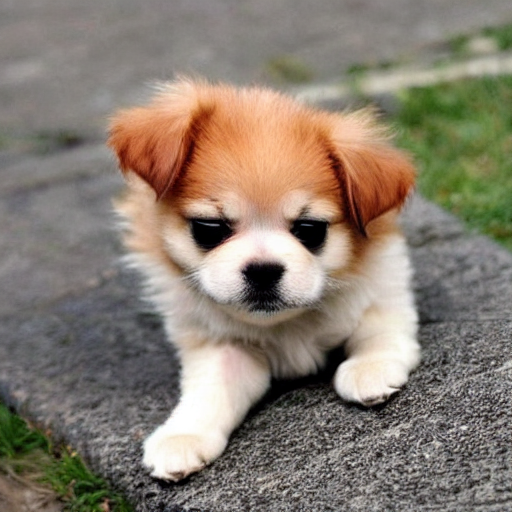

In [89]:
# autocast makes the code run faster
with autocast(device):
  image = pipe(prompt).images[0]

image

In [90]:
# displays number of specified images in a grid format
def image_grid(imgs, rows, cols):
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/50 [00:00<?, ?it/s]

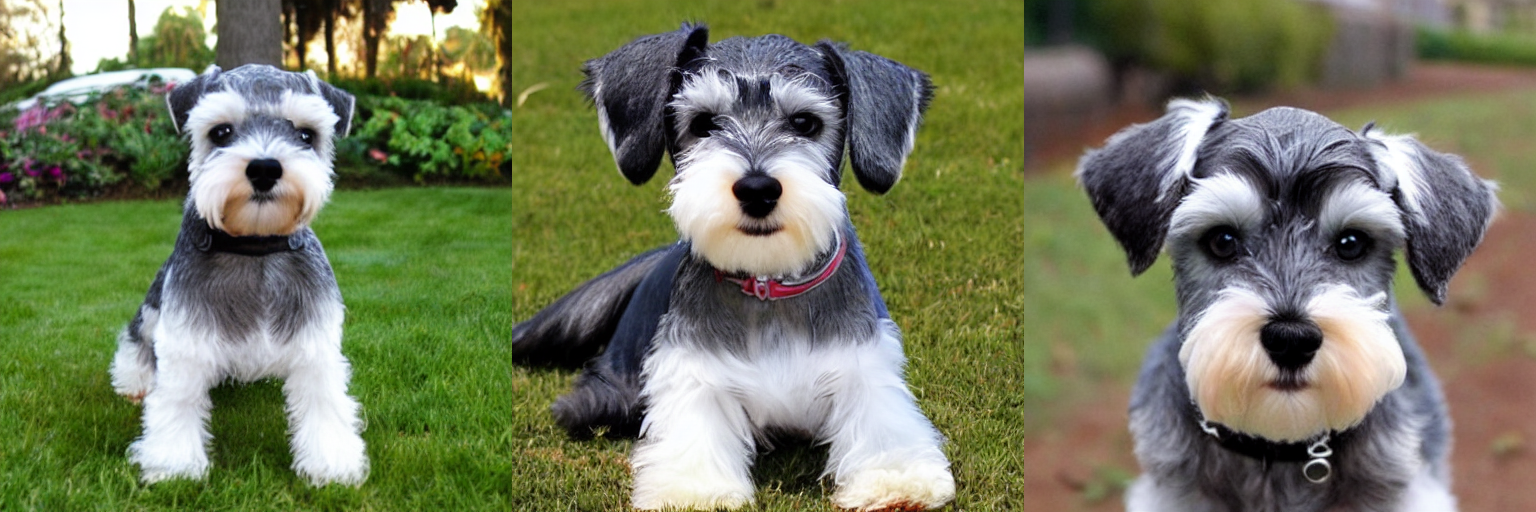

In [91]:
imageNumber = 3
prompts = ['cute mini schnauzer'] * imageNumber
images = pipe(prompts).images
image_grid(images, rows=1, cols=3)

Customize and Load Your Own Model

In [92]:
from huggingface_hub import notebook_login
notebook_login()

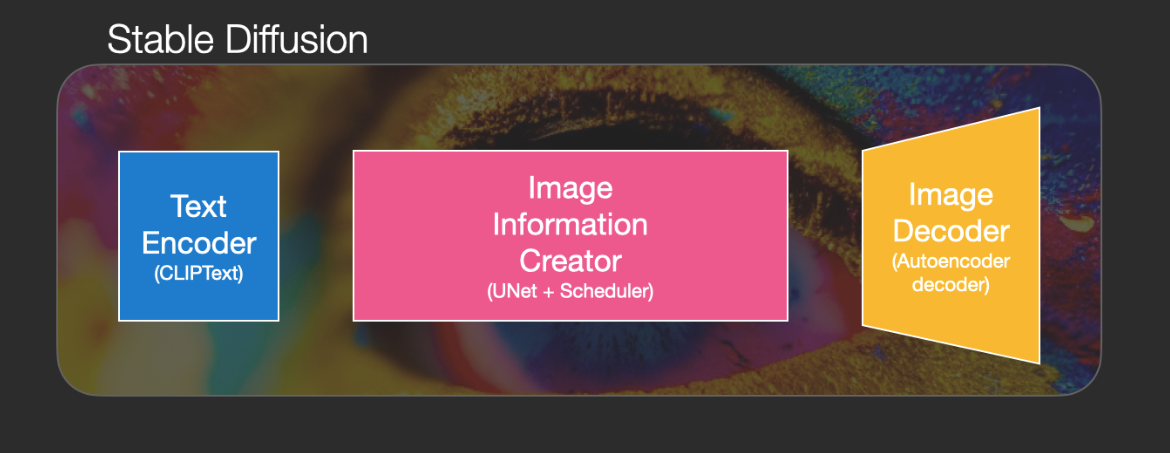

image source: https://jalammar.github.io/illustrated-stable-diffusion/

In [93]:
# (1) Text Encoder

# load the tokenizer (will take each word in the prompt and turn it into a number)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

# load the encoder (prepares the prompt for the model by converting every number into a vector)
text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
text_encoder = text_encoder.to(device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.v_proj.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.21.self_attn.out_proj.bias', 'vision_model.encoder.layers.10.mlp.fc2.weight', 'vision_model.encoder.layers.0.self_attn.q_proj.bias', 'vision_model.encoder.layers.15.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.weight', 'vision_model.encoder.layers.9.layer_norm2.weight', 'vision_model.encoder.layers.13.self_attn.q_proj.bias', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers.23.mlp.fc1.weight', 'vision_model.encoder.layers.13.mlp.fc2.bias', 'vision_model.encoder.layers.3.layer_norm2.weight', 'vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.17.mlp.fc2.weight', 'vision_model.encoder.layers.2.mlp.fc1.weight', 'vision_model.encoder.layers.1.

In [94]:
# (2.1) UNet model for generating latents (noise predictor)
unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet')
unet = unet.to(device)

In [95]:
# (2.2) Scheduler for inference (dont want to subtract the same amount of noise in each step, so the scheduler determines how much noise to subtract in each step)
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear', num_train_timesteps=1000)

In [96]:
# (3) Autoencoder model (use the decoder part to turn denoised latents into an image)
vae = AutoencoderKL.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='vae')
vae = vae.to(device)

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


In [97]:
# set parameters for image generation
prompt = ["cute dog"]

height = 512                    
width = 512           

num_inference_steps = 100            # number of denoising steps
guidance_scale = 7.5                # scale for classifier-free guidance
generator = torch.manual_seed(32)   # seed generator to create the inital latent noise
batch_size = 1

In [98]:
# tokenize text and get embeddings
text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length, truncation=True, return_tensors='pt')

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

# unconditional text embedding (to make padding same size as token embedding)
uncond_input = tokenizer([''] * len(prompt), padding='max_length', max_length=tokenizer.model_max_length, return_tensors='pt')
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0] 

# combine conditioned and unconditioned embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [99]:
# generate random noise for the image
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(device)

In [100]:
scheduler.set_timesteps(num_inference_steps)
latents = latents * scheduler.sigmas[0]

In [101]:
with autocast("cuda"):
    for t in tqdm(scheduler.timesteps):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)

      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

In [102]:
# use vae decoder to decompress and decode image
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

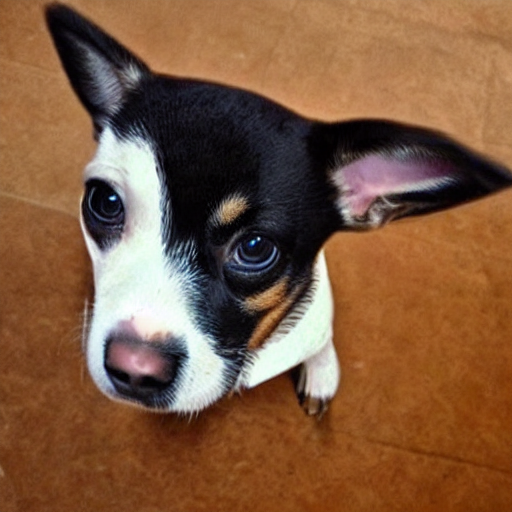

In [103]:
# image tensor to viewable image
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]